**The purpose of this notebook is to visualize the distribution of prediction errors (or deviations) in $u$, $h$, and $B$ over multiple trials. It assumes that the prediction errors (or deviations) are organized into ```numpy``` arrays with a specific format (see the section titled "trial_results" in the README). If you have not yet combined individual trial results for a given set of hyperparameter settings, please refer to 'trial_processing.ipynb' , which provides sample code for processing multiple python dictionaries of results from individual trials stored as ```.mat``` files by the training script ("pinn_trial.py").**

**We also provide code for running $k$-means clustering in $\log$-space, and plotting the average and standard deviation of low- and high-error cluster errors as a function of $\gamma$ for different noise levels. We also provide sample code for visualizing the distribution of trial error over a set of trials, like the plots in Figures 1 and 2 of the README.**

In [1]:
from matplotlib import pyplot as plt
from scipy.io import loadmat
import sys
import time
from pathlib import Path
import math as m
from tqdm import tqdm
from sklearn.cluster import KMeans
import numpy as np

In [2]:
# # Set parameters
# spy = 60 * 60 * 24 * 365.25
# rhoi = 910.
# rhow = 1028.
# delta = 1. - rhoi / rhow
# g = 9.81
# a = 0.3 / spy
# Q0 = 4.0e5 / spy
# H0 = 1.0e3
# B0 = 1.4688e8
# n = 3

# # Set scalings
# Z0 = a ** (1/(n+1)) * (4 * B0) ** (n / (n + 1)) / (rhoi * g * delta) ** (n/(n + 1))
# U0 = 400 / spy
# Lx = U0 * Z0 / a
# h0 = H0 / Z0; q0 = Q0 / (U0 * Z0)
# nu_star = (2 * B0) / ( rhoi * g * delta * Z0) * (U0 / Lx) ** (1 / n)
# A0 = (a * Lx) / (U0 * Z0)

# #analytic h (analytic solution for thickness h(x), for a constant hardness profile B(x)=1)
# def analytic_h_constantB(x):
#     return ((A0 * h0 ** (n + 1) * (A0 * x + q0) ** (n + 1)) / (
#             A0 * q0 ** (n + 1) - (q0 * h0) ** (n + 1) + (h0 * (A0 * x + q0)) ** (n + 1))) ** (1 / (n + 1))

# #analytic u (analytic solution for velocity u(x), for a constant hardness profile B(x)=1)
# def analytic_u_constantB(x):
#     return (A0 * x + q0) / analytic_h_constantB(x)

# x_star = np.linspace(start = 0.0, stop = 1.0, num = 401)

# #define tested values of gammas as an array of strings for convenient plotting.
legend_gammas = np.array(['$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^{0}$', 
                 '$10^{1}$', '$10^{2}$', '$10^{3}$', '$10^{4}$', '$10^{5}$',
                 '$10^{6}$', '$10^{7}$','$10^{8}$' ])



**1) Visualize the distribution of trial errors for specific values of $\gamma$**.

In [7]:
#define gamma_ratios being tested. These are pre-defined here because they are the values of $\gamma$ tested in the default training scheme. If different $\gamma$-values were used, this must be modified
#accordingly, as well as the indices specified in the code below.
lnratios = np.linspace(-4,8,13)
gamma_ratios = np.power(10.0, lnratios)

In [8]:
#load numpy array of trials. Replace with the correct path to file in the 'trial_results' folder.
clean_errs = np.load('clean_u206l1kc_errs.npy')
n05_errs = np.load('n05_u206l1kc_errs.npy')
n1_errs = np.load('n1_u206l1kc_errs.npy')
n3_errs = np.load('n3_u206l1kc_errs.npy')

Text(0, 0, '(f)')

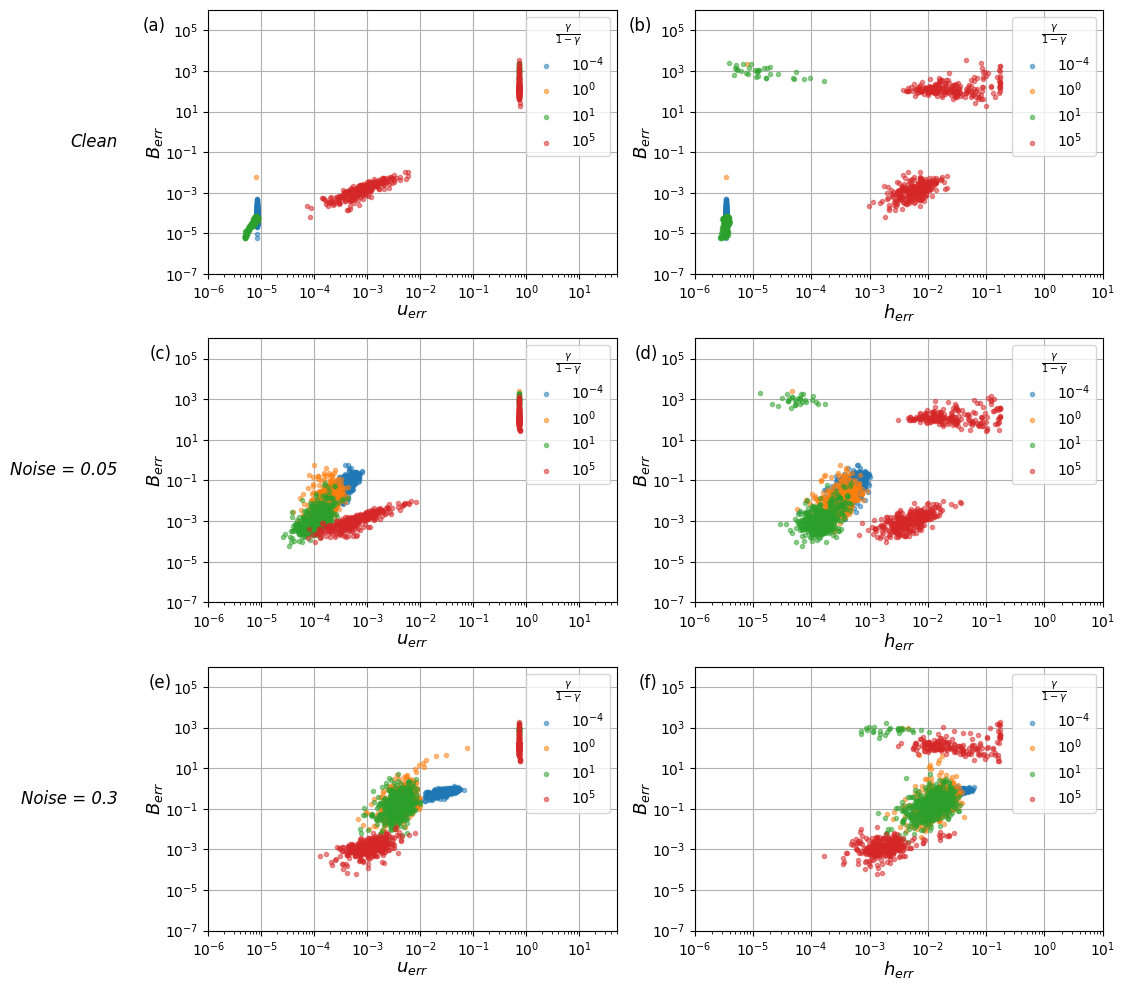

In [9]:
#Make cluster plots to visualize distribution for each noise-level gamma setting. 
#specify the indices of the gamma values to compare differences between noise levels.
indices = [0,4,5,9]
fig, ax = plt.subplots(nrows=3, ncols = 2, figsize = (10,10))
for i in indices:
    ax[0][0].loglog(clean_errs[i][0], clean_errs[i][2],'o', alpha = 0.5, markersize = 3)
    ax[0][1].loglog(clean_errs[i][1], clean_errs[i][2],'o', alpha = 0.5, markersize = 3)
    
    ax[1][0].loglog(n05_errs[i][0], n05_errs[i][2],'o', alpha = 0.5, markersize = 3)
    ax[1][1].loglog(n05_errs[i][1], n05_errs[i][2],'o', alpha = 0.5, markersize = 3)
    
    ax[2][0].loglog(n3_errs[i][0], n3_errs[i][2],'o', alpha = 0.5, markersize = 3)
    ax[2][1].loglog(n3_errs[i][1], n3_errs[i][2],'o', alpha = 0.5, markersize = 3)


for k in range(3):
    ax[k][0].set_xlabel('$u_{err}$', fontsize = 13, labelpad = 0)
    ax[k][1].set_xlabel('$h_{err}$', fontsize = 13, labelpad = 0)

for i in range(3):
    ax[i][0].set_xlim([10**(-6),5*10])
    ax[i][1].set_xlim([10**(-6),10])
    for j in range(2):
        ax[i][j].grid()
        ax[i][j].legend(legend_gammas[indices], title = '$\\frac{\gamma}{1-\gamma}$')
        ax[i][j].set_ylabel('$B_{err}$', fontsize = 13, labelpad = 0)
        ax[i][j].set_ylim([10**(-7),10**6])
plt.tight_layout()
pad = 20
ax[0][0].annotate('Clean', xy=(0, 0.5), xycoords=ax[0][0].yaxis.label, xytext=(-ax[0][0].yaxis.labelpad - pad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='center', style = 'italic')
ax[1][0].annotate('Noise = 0.05', xy=(0, 0.5), xycoords=ax[1][0].yaxis.label, xytext=(-ax[1][0].yaxis.labelpad - pad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='center', style = 'italic')
ax[2][0].annotate('Noise = 0.3', xy=(0, 0.5), xycoords=ax[2][0].yaxis.label, xytext=(-ax[2][0].yaxis.labelpad - pad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='center', style = 'italic')

ax[0][0].annotate('(a)', xy=(1, 4.0), xycoords=ax[0][0].yaxis.label, xytext=(-ax[0][0].yaxis.labelpad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='center')
ax[0][1].annotate('(b)', xy=(1, 4.0), xycoords=ax[0][1].yaxis.label, xytext=(-ax[0][1].yaxis.labelpad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='center')


ax[1][0].annotate('(c)', xy=(1.3, 4.0), xycoords=ax[1][0].yaxis.label, xytext=(-ax[1][0].yaxis.labelpad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='center')
ax[1][1].annotate('(d)', xy=(1.3, 4.0), xycoords=ax[1][1].yaxis.label, xytext=(-ax[1][1].yaxis.labelpad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='center')

ax[2][0].annotate('(e)', xy=(1.3, 4.0), xycoords=ax[2][0].yaxis.label, xytext=(-ax[2][0].yaxis.labelpad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='center')
ax[2][1].annotate('(f)', xy=(1.3, 4.0), xycoords=ax[2][1].yaxis.label, xytext=(-ax[2][1].yaxis.labelpad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='center')


**2) Define a helper function "cluster_statistics", which runs $k$-means clustering on a numpy array of errors from multiple values of $\gamma$.**

In [3]:
# input arguments: numpy array of errors, single gamma index  for overlaying good solutions (typically optimal gamma, but you can set opt_g to any index of interest.
#num_gammas: number of gamma values that were tested in this dataset. Default is 13.
#if good_indices argument is set to "True", the function will return arrays of indices of the trials in low-error clusters (gi) 
#and high-error clusters (bi).
#this is useful for visualizing all low-error accuracy predictive profiles at once.
#if good_indices argument is set to "False, it will not return the good indices"

#returns:
#low: low error cluster average
#low_std: low error cluster std
#high: high error cluster average
#high_std: high error cluster std
#ic_distance: intercluster distance --> distance between the two means found by k-means algorithm
#low_count: count of low error clusters
#err_centers: centers of the k-mean clusters
#gi: good indices
#bi: bad indices

def cluster_statistics(errors, opt_g=6, good_indices = False, num_gammas = 13):
    low = np.zeros(shape = (num_gammas,3), dtype = float) #low-error cluster averages
    low_std = np.zeros(shape = (num_gammas,3), dtype = float) #low-error cluster std
    high_std = np.zeros(shape = (num_gammas,3), dtype = float) #high-error cluster std

    high = np.zeros(shape = (num_gammas,3), dtype = float) #high-error cluster averages
    low_count = np.zeros(shape=num_gammas, dtype=int)
    err_centers = np.zeros(shape = (num_gammas,2,3))

    for gamma in range(num_gammas):
        kmeans = KMeans(n_clusters=2, n_init='auto').fit(np.log10(errors[gamma]).T)
        centers = kmeans.cluster_centers_
        err_centers[gamma][0] = centers[0]
        err_centers[gamma][1] = centers[1]

        zeros = np.argwhere(kmeans.labels_==0)
        ones = np.argwhere(kmeans.labels_==1)
        if centers[0][2] < centers[1][2]:
            low[gamma]=np.mean(errors[gamma,:,zeros], axis = 0)[0]
            low_std[gamma]=np.std(errors[gamma,:,zeros], axis = 0)[0]
            high[gamma]=np.mean(errors[gamma,:,ones], axis = 0)[0]
            high_std[gamma]=np.std(errors[gamma,:,ones], axis = 0)[0]

            low_count[gamma] = zeros.size
            err_centers[gamma][0] = centers[0]
            err_centers[gamma][1] = centers[1]


            if gamma == opt_g:
                gi = zeros.flatten()
                bi = ones.flatten()

        else:
            low[gamma]=np.mean(errors[gamma,:,ones], axis = 0)[0]
            low_std[gamma]=np.std(errors[gamma,:,ones], axis = 0)[0]
            high[gamma]=np.mean(errors[gamma,:,zeros], axis = 0)[0]
            high_std[gamma]=np.std(errors[gamma,:,zeros], axis = 0)[0]
            low_count[gamma] = ones.size
            err_centers[gamma][0] = centers[1]
            err_centers[gamma][1] = centers[0]


            if gamma == opt_g:
                gi = ones.flatten()
                bi = zeros.flatten()


    low = low.T
    low_std = low_std.T
    high = high.T
    high_std = high_std.T
    ic_distance = np.linalg.norm(np.subtract(np.power(10,err_centers[:,0,:]),np.power(10,err_centers[:,1,:])),axis = 1)
    
    if good_indices:
            return low, low_std, high, high_std, ic_distance, low_count, err_centers, gi, bi
    else:
            return low, low_std, high, high_std, ic_distance, low_count, err_centers

In [11]:
#here we run the function "cluster_statistics" on the actual data sets presented in the paper using the default setting of PINN for a range of noise levels  (i.e. Figure 3 of the Supplementary Material)
clean_low, clean_low_std, clean_high,clean_high_std, clean_ic_distance, clean_low_count, clean_err_centers=cluster_statistics(clean_errs)
n05_low, n05_low_std, n05_high,n05_high_std, n05_ic_distance, n05_low_count, n05_err_centers=cluster_statistics(n05_errs)
n1_low, n1_low_std, n1_high,n1_high_std, n1_ic_distance, n1_low_count, n1_err_centers=cluster_statistics(n1_errs)
n3_low, n3_low_std, n3_high,n3_high_std, n3_ic_distance, n3_low_count, n3_err_centers=cluster_statistics(n3_errs)


**3) Plot average $u_{err}$, $h_{err}$, and $B_{err}$ for low-error clusters determined by $k$-means. This code reproduces Figure 5 of the main text.**

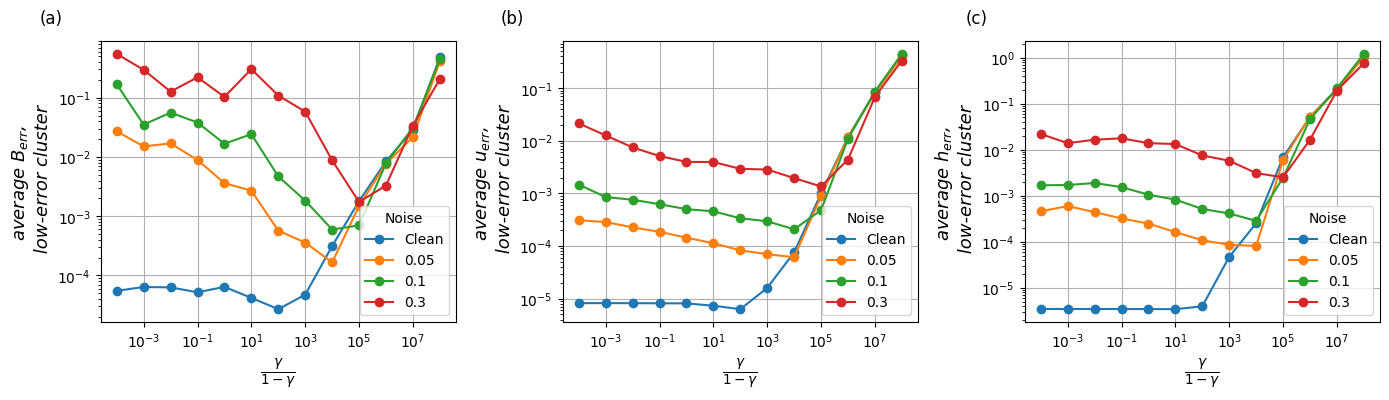

In [12]:
fig, ax = plt.subplots(nrows=1, ncols = 3, figsize = (14,4))
for i in range(3):
    ax[(i+1)%3].loglog(gamma_ratios, clean_low[i], marker ='o', label = 'Clean')
    ax[(i+1)%3].loglog(gamma_ratios, n05_low[i], marker ='o', label = '0.05')
    ax[(i+1)%3].loglog(gamma_ratios, n1_low[i], marker ='o', label = '0.1')
    ax[(i+1)%3].loglog(gamma_ratios, n3_low[i], marker ='o', label = '0.3')
    ax[(i+1)%3].legend(title='Noise',loc='lower right')
    ax[(i+1)%3].set_xlabel('$\\frac{\gamma}{1-\gamma}$', fontsize = 14)
    ax[(i+1)%3].grid()

ax[0].set_ylabel('average $B_{err}$, \n low-error cluster', fontsize = 13, style='italic')
ax[1].set_ylabel('average $u_{err}$, \n low-error cluster', fontsize = 13, style='italic')
ax[2].set_ylabel('average $h_{err}$, \n low-error cluster', fontsize = 13, style='italic')
plt.tight_layout()
ax[0].annotate('(a)', xy=(1.4,1.5), xycoords=ax[0].yaxis.label, xytext=(-ax[0].yaxis.labelpad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='bottom')
ax[1].annotate('(b)', xy=(1.4,1.5), xycoords=ax[1].yaxis.label, xytext=(-ax[1].yaxis.labelpad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='bottom')
ax[2].annotate('(c)', xy=(1.4,1.5), xycoords=ax[2].yaxis.label, xytext=(-ax[2].yaxis.labelpad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='bottom')
plt.tight_layout()

**4) Plot low-error trial count and intercluster distance. This code reproduces Figure 7 of the main text.**

Text(-4.0, 0, '(b)')

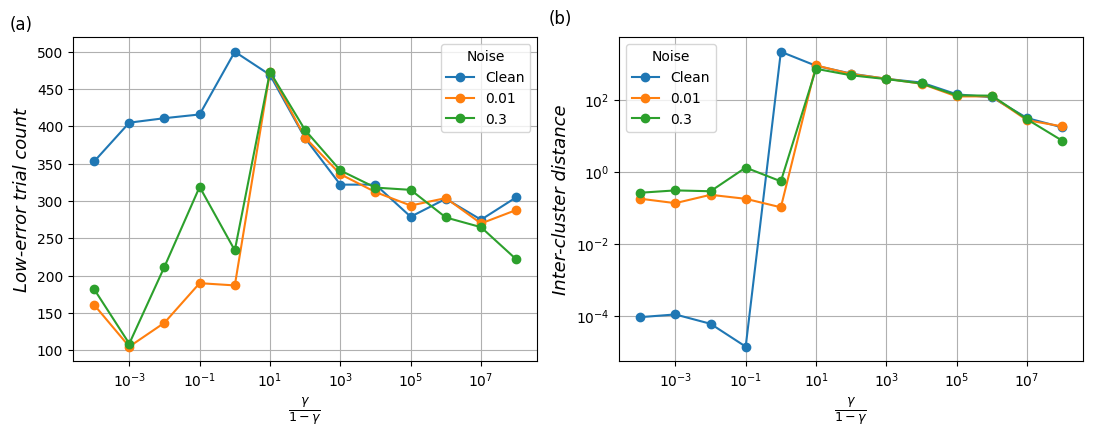

In [13]:
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize = (11,4.2))

ax[0].semilogx(gamma_ratios, clean_low_count, marker='o',label='Clean')
ax[0].semilogx(gamma_ratios,n1_low_count, marker='o',label='0.01')
ax[0].semilogx(gamma_ratios,n3_low_count,marker='o',label='0.3')

ax[1].loglog(gamma_ratios, clean_ic_distance, marker='o', label = 'Clean')
ax[1].loglog(gamma_ratios, n1_ic_distance, marker='o', label = '0.01')
ax[1].loglog(gamma_ratios, n3_ic_distance, marker='o', label = '0.3')


for i in range(2):
    ax[i].grid()
    ax[i].set_xlabel('$\\frac{\gamma}{1-\gamma}$', fontsize = 13)
    ax[i].legend(title='Noise')
ax[0].set_ylabel('Low-error trial count', fontsize = 13, style ='italic')
ax[1].set_ylabel('Inter-cluster distance', fontsize = 13, style ='italic')
plt.tight_layout()

ax[0].annotate('(a)', xy=(1.4,1.4), xycoords=ax[0].yaxis.label, xytext=(-ax[0].yaxis.labelpad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='bottom')
ax[1].annotate('(b)', xy=(1.4,1.4), xycoords=ax[1].yaxis.label, xytext=(-ax[1].yaxis.labelpad, 0), textcoords = 'offset points', size = 'large', ha = 'right', va ='bottom')
